# Modèles de régression (sur le jeu de données complété des nouvelles features)

### Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
from random import sample
from scipy import stats
from sklearn import linear_model, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

%matplotlib inline

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
sns.set(rc={'figure.figsize': (12, 8)})
sns.set(rc={'font.size': 15})

os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/04 - Projet 4 - Retards/Main project")

In [2]:
def distri_plot(Var, X):
    """Fonction permettant d'afficher la distribution statistique d'une variable (courbe + histogramme)"""
    sns.distplot(Var)
    plt.xlabel(X, fontsize=18)
    plt.ylabel("Distribution", fontsize=18)
    plt.title("Distribution de " + X, fontsize=24)
    print("La médiane de ", X, "est de ", Var.median())
    print("La moyenne de ", X, "est de ", Var.mean())


def boxplot1d(X, title):
    """Fonction permettant d'afficher la distribution statistique d'une variable en boite à moustache"""
    sns.boxplot(X)
    plt.title(title, fontsize=24)
    print(X.describe())


def evaluate_completnes_df(data):
    "Création de la fonction pour évaluer la complétion d'un jeu de données"
    IsNull = pd.isnull(data)
    EmptynessRatio = IsNull.sum().sum()/data.size
    return (print("La matrice est complète à :",
                  np.around((1-EmptynessRatio), decimals=3)*100, "%"))

### Import du data set 

In [3]:
data = pd.read_csv('data_meteo.csv', low_memory=False, error_bad_lines=False)

Une colonne inutile 'Unnamed: 0' est apparue dans notre data set, nous la supprimons

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.dtypes

MONTH             int64
DAY_OF_MONTH    float64
DAY_OF_WEEK     float64
AIRLINE_ID       object
ARR_DELAY       float64
DISTANCE        float64
hdays             int64
DEP_HOUR        float64
Prec              int64
Vent              int64
Nuage             int64
EML              object
WE                int64
dtype: object

In [6]:
data.head(10)

MONTH  DAY_OF_MONTH  DAY_OF_WEEK                  AIRLINE_ID  ARR_DELAY  \
0      5          23.0          1.0  American Airlines Inc.: AA      -13.0   
1     12          19.0          1.0          Virgin America: VX       13.0   
2      2          18.0          4.0    Delta Air Lines Inc.: DL      -22.0   
3      9          21.0          3.0  Southwest Airlines Co.: WN      -10.0   
4      8           4.0          4.0   United Air Lines Inc.: UA       -9.0   
5      7          19.0          2.0    Delta Air Lines Inc.: DL      -14.0   
6      1          27.0          3.0    Delta Air Lines Inc.: DL      -28.0   
7     12           9.0          5.0   SkyWest Airlines Inc.: OO        9.0   
8     11           4.0          5.0        Spirit Air Lines: NK      -18.0   
9     11          19.0          6.0  American Airlines Inc.: AA      -25.0   

   DISTANCE  hdays  DEP_HOUR  Prec  Vent  Nuage    EML  WE  
0     936.0      7      22.0     3    19     50   late   0  
1    2586.0      6      12.0     3    18     61    Mid   0  
2     332.0      3      16.0     3    20     54    Mid   0  
3     407.0     16      18.0     3    17     40   late   0  
4     337.0     31       9.0     4    17     41    Mid   0  
5    1589.0     15       8.0     3    18     38  Early   0  
6    1013.0      9       5.0     3    18     60  Early   0  
7      73.0     15      20.0     3    18     61   late   0  
8     581.0     20       8.0     2    17     45  Early   0  
9    2475.0      5      10.0     2    17     45    Mid   1

## Suppression des outliers (méthode LOF)

Nous décidons de filtrer les outliers par la méthode LocalOutlierFactor.
En effet les outliers pertubent les modèles de régression, et causent des prévisions moins précises. 
Notre choix de supprimer les outliers malgré la perte d'information que peut en subir le modèle vient du fait que 
d'une part nous augmentons significativement la précision des modèles et d'autre part les vols considérés comme outlier 
par l'algorithme LOF sont des vols aux caractéristiques particulières, sur lesquels nous avons peu d'informations 
et qui sont moins susceptibles d'être emprunté par un utilisateur

In [7]:
data_LOF = data.drop(['AIRLINE_ID', 'EML'], axis=1)

In [8]:
from sklearn.neighbors import LocalOutlierFactor
print(data.shape)

LOF = LocalOutlierFactor()
LOF_score = LOF.fit_predict(data_LOF)

print('il y a ', np.bincount(LOF_score + 1)[0], ' outliers detectés')

data = data.drop(np.where(LOF_score == -1)[0], axis=0)

print(data.shape)

(422011, 13)
il y a  42202  outliers detectés
(379809, 13)


On supprime quelques 10% des vols présents dans notre jeu de données

## Etude de corrélation

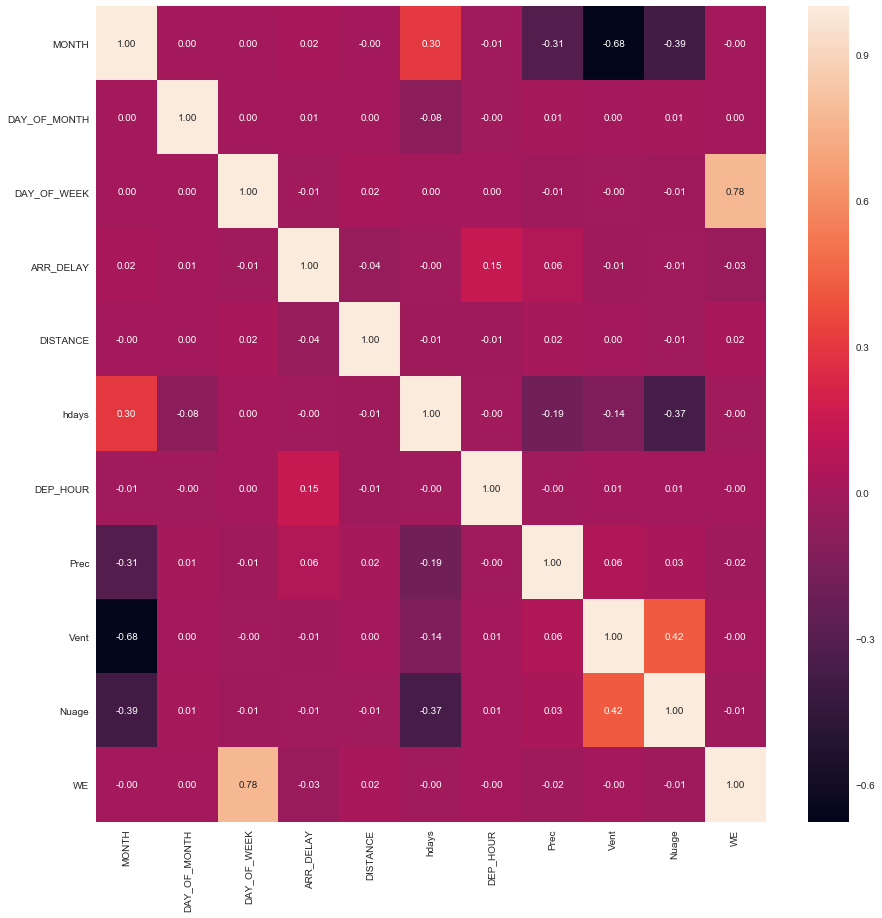

In [9]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cbar=True)

Evidémment le jour de la semaine est corrélé à la variable Weekend. 
Sinon seulement 2 variables météorologiques sont légèrement corrélées

# Traitement des variables catégorielles

In [10]:
data['AIRLINE_ID'].nunique()

12

Différenciation des variables catégorielles des variables numériques

In [11]:
Num = ['hdays', 'DISTANCE', 'Prec', 'Vent', 'Nuage']
Cat = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_HOUR', 'AIRLINE_ID', 'EML','WE']

In [12]:
data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].apply(str)
data['DAY_OF_MONTH'] = data['DAY_OF_MONTH'].apply(str)
data['MONTH'] = data['MONTH'].apply(str)
data['DEP_HOUR'] = data['DEP_HOUR'].apply(str)
data['AIRLINE_ID'] = data['AIRLINE_ID'].apply(str)
data['EML'] = data['EML'].apply(str)

On réalise le One Hot Encoding de nos variables catégorielles grace à la fonction get_dummies de pandas

In [13]:
dummies = pd.get_dummies(data[Cat])

In [14]:
data2 = pd.concat([data, dummies], axis=1)
data2 = data2.drop(Cat, axis=1)
data2.head()

ARR_DELAY  DISTANCE  hdays  Prec  Vent  Nuage  MONTH_1  MONTH_10  MONTH_11  \
0      -13.0     936.0      7     3    19     50        0         0         0   
1       13.0    2586.0      6     3    18     61        0         0         0   
2      -22.0     332.0      3     3    20     54        0         0         0   
3      -10.0     407.0     16     3    17     40        0         0         0   
4       -9.0     337.0     31     4    17     41        0         0         0   

   MONTH_12    ...     AIRLINE_ID_Hawaiian Airlines Inc.: HA  \
0         0    ...                                         0   
1         1    ...                                         0   
2         0    ...                                         0   
3         0    ...                                         0   
4         0    ...                                         0   

   AIRLINE_ID_JetBlue Airways: B6  AIRLINE_ID_SkyWest Airlines Inc.: OO  \
0                               0                                     0   
1                               0                                     0   
2                               0                                     0   
3                               0                                     0   
4                               0                                     0   

   AIRLINE_ID_Southwest Airlines Co.: WN  AIRLINE_ID_Spirit Air Lines: NK  \
0                                      0                                0   
1                                      0                                0   
2                                      0                                0   
3                                      1                                0   
4                                      0                                0   

   AIRLINE_ID_United Air Lines Inc.: UA  AIRLINE_ID_Virgin America: VX  \
0                                     0                              0   
1                                     0                              1   
2                                     0                              0   
3                                     0                              0   
4                                     1                              0   

   EML_Early  EML_Mid  EML_late  
0          0        0         1  
1          0        1         0  
2          0        1         0  
3          0        0         1  
4          0        1         0  

[5 rows x 96 columns]

Identification de la variable cible

In [15]:
X = data2.drop(['ARR_DELAY'], axis=1)
y = data2['ARR_DELAY'].values

Séparation Train - Test

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

In [17]:
X_train.shape

(284856, 95)

In [18]:
X_train_num = X_train[Num]
X_test_num = X_test[Num]

### Normalisation des variables

On réalise la normalisation de nos variables numériques, en ne réalisant bien le fit de notre scaler sur les données 'train' seulement

In [19]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_num)
X_train_sc = scaler.transform(X_train_num)
X_test_sc = scaler.transform(X_test_num)

In [20]:
X_train.loc[:, 0:5] = X_train_sc
X_test.loc[:, 0:5]= X_test_sc

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
X_train.columns

Index(['DISTANCE', 'hdays', 'Prec', 'Vent', 'Nuage', 'MONTH_1', 'MONTH_10',
       'MONTH_11', 'MONTH_12', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5',
       'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'DAY_OF_MONTH_1.0',
       'DAY_OF_MONTH_10.0', 'DAY_OF_MONTH_11.0', 'DAY_OF_MONTH_12.0',
       'DAY_OF_MONTH_13.0', 'DAY_OF_MONTH_14.0', 'DAY_OF_MONTH_15.0',
       'DAY_OF_MONTH_16.0', 'DAY_OF_MONTH_17.0', 'DAY_OF_MONTH_18.0',
       'DAY_OF_MONTH_19.0', 'DAY_OF_MONTH_2.0', 'DAY_OF_MONTH_20.0',
       'DAY_OF_MONTH_21.0', 'DAY_OF_MONTH_22.0', 'DAY_OF_MONTH_23.0',
       'DAY_OF_MONTH_24.0', 'DAY_OF_MONTH_25.0', 'DAY_OF_MONTH_26.0',
       'DAY_OF_MONTH_27.0', 'DAY_OF_MONTH_28.0', 'DAY_OF_MONTH_29.0',
       'DAY_OF_MONTH_3.0', 'DAY_OF_MONTH_30.0', 'DAY_OF_MONTH_31.0',
       'DAY_OF_MONTH_4.0', 'DAY_OF_MONTH_5.0', 'DAY_OF_MONTH_6.0',
       'DAY_OF_MONTH_7.0', 'DAY_OF_MONTH_8.0', 'DAY_OF_MONTH_9.0',
       'DAY_OF_WEEK_1.0', 'DAY_OF_WEEK_2.0', 'DAY_OF_WEEK_3.0',
       'DAY_OF_WEEK_4.

In [22]:
import pickle
index_dict = dict(zip(X_train.columns,range(X_train.shape[1])))

with open('index', 'wb') as fid:
    pickle.dump(index_dict, fid,2)

# Modèles 

## Modèle naif (prédiction par la moyenne), pour comparaison 

In [23]:
Mean = y_train.mean()
print(Mean)

-3.2744614822928075


In [24]:
print('baseline total error is : ', np.mean((Mean - y_test) ** 2))
mean = np.ones(len(y_test))*Mean
print('baseline MAE is : ', mean_absolute_error(mean, y_test))
print('baseline RMSE is : ', sqrt(mean_squared_error(y_test, mean)))

baseline total error is :  276.25016767098197
baseline MAE is :  12.150355511869911
baseline RMSE is :  16.620775182613535


In [25]:
def pred_by_mean():
    return round(Mean, 3)

import pickle 
with open('Mean.pkl', 'wb') as fid:
    pickle.dump(pred_by_mean(), fid)

## Regression linéaire multiple

In [26]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)
pred = LR.predict(X_test)
baseline_error = np.mean((pred - y_test) ** 2)
print('score on train is : ', LR.score(X_train, y_train))
print('total error is : ', baseline_error)
print('MAE is : ', mean_absolute_error(y_test, pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, pred)))

score on train is :  0.05528597673777746
total error is :  260.81008195543126
MAE is :  11.861034373584825
RMSE is :  16.149615535839583


### Visualisation des features

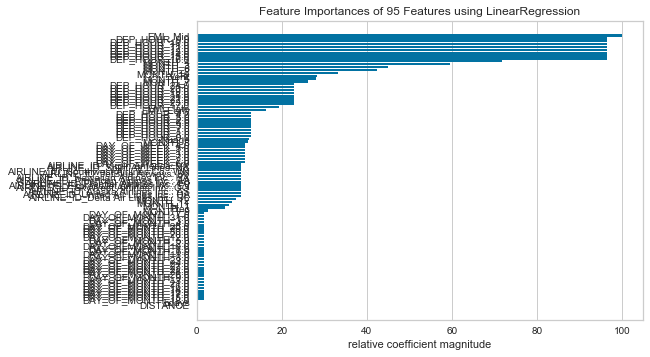

In [27]:
from yellowbrick.features.importances import FeatureImportances
viz = FeatureImportances(LinearRegression(), absolute=True)
viz.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
viz.poof()
plt.show()

Text(0.5,1,'Importance relative des 10 principales features, Regression Linéaire')

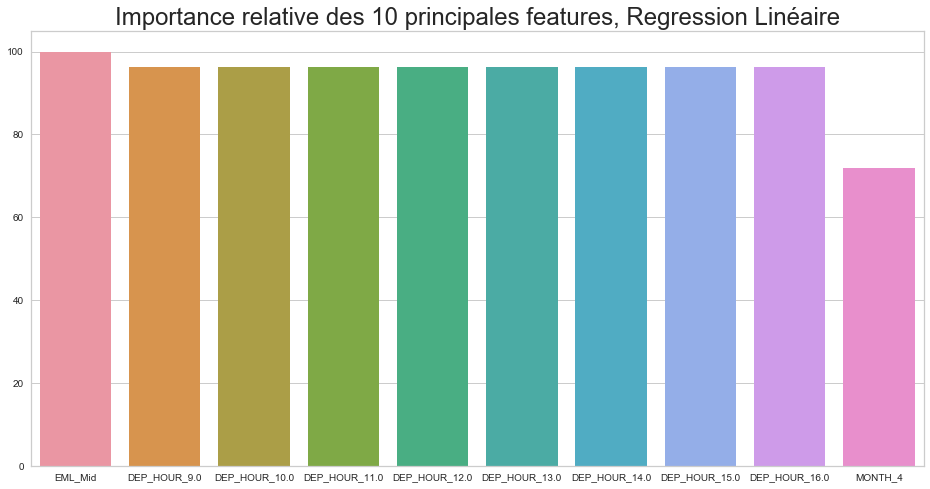

In [28]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
sns.barplot(x=viz.features_[::-1][0:10], y=(viz.feature_importances_[::-1][0:10]))
plt.title('Importance relative des 10 principales features, Regression Linéaire', fontsize=24)

Text(0.5,1,'Importance relative des 10 principales features, Regression Linéaire')

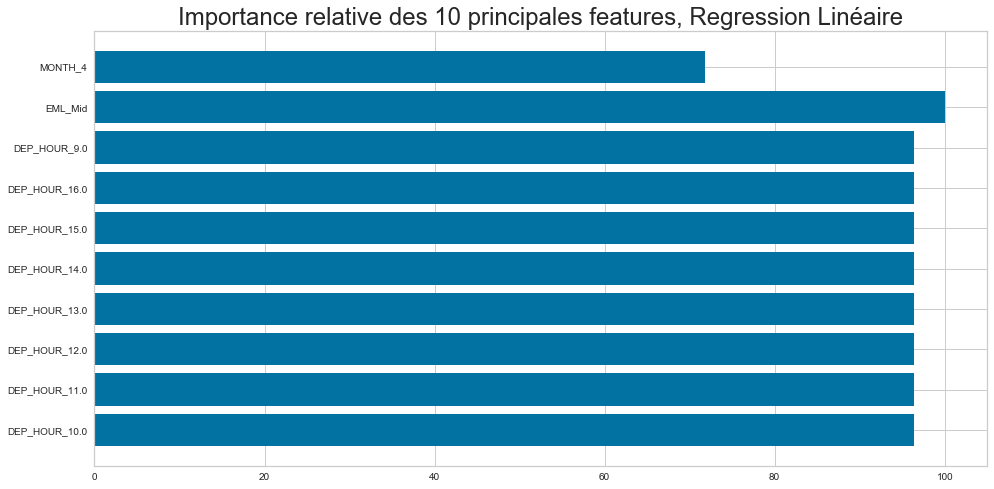

In [29]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
plt.barh(y=viz.features_[::-1][0:10], width=(viz.feature_importances_[::-1][0:10]))
plt.title('Importance relative des 10 principales features, Regression Linéaire', fontsize=24)

De nombreuses variables possèdent la même importance, ce n'est pas forcément souhaitable pour l'analyse du modèle

Cross Validation

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
LR = LinearRegression()
LR.fit(X_train, y_train)
LR_pred = cross_val_predict(LR, X_test, y_test, cv=10)
error = np.mean((LR_pred - y_test) ** 2)
print('score on train is : ', LR.score(X_train, y_train))
print('total error is : ', error)
print('MAE is : ', mean_absolute_error(y_test, LR_pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, LR_pred)))

score on train is :  0.05528597673777746
total error is :  260.8570487707317
MAE is :  11.854709722265762
RMSE is :  16.15106958596649


## Regression Ridge 

In [31]:
from sklearn.linear_model import Ridge
n_alphas = 200
alphas = np.logspace(-3, 7, n_alphas)
ridge = Ridge()
coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean(
        (ridge.predict(X_test) - y_test) ** 2)])

Evolution des coefficients en fonction du paramètre de régularisation alpha

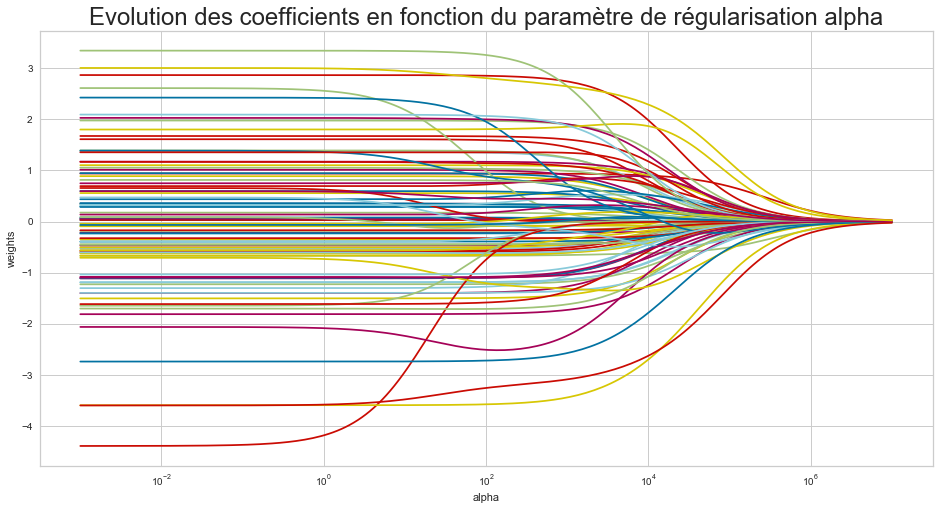

In [32]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Evolution des coefficients en fonction du paramètre de régularisation alpha', fontsize=24)
plt.axis('tight')
plt.show()

Evolution de l'erreur en fonction du paramètre de régularisation alpha

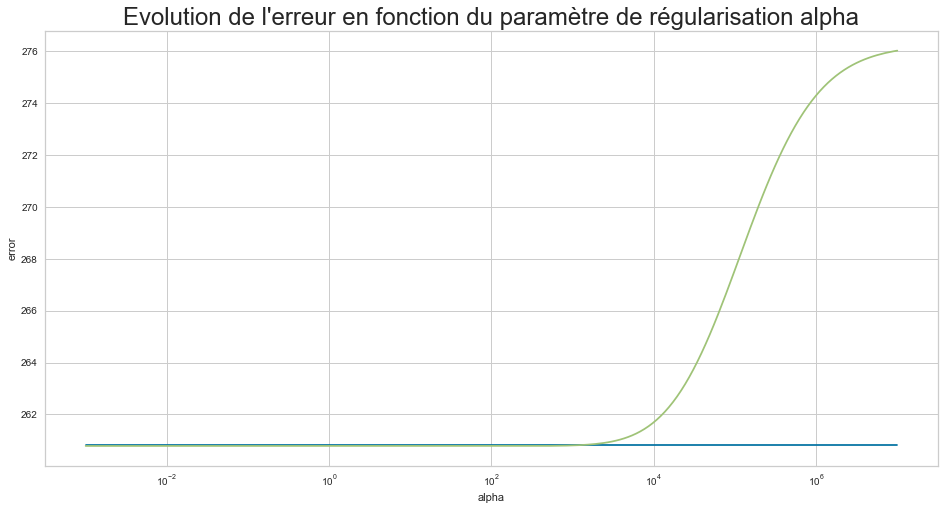

In [33]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title("Evolution de l'erreur en fonction du paramètre de régularisation alpha",  fontsize=24)
plt.axis('tight')
plt.show()

La régression Ridge ne permet pas d'améliorer réellement les performances de notre modèle

Modèle permettant l'optimisation automatique du paramètre alpha

In [34]:
from sklearn.linear_model import RidgeCV
RCV = RidgeCV()
RCV.fit(X_train, y_train)
Pred = RCV.predict(X_test)
error = np.mean((Pred - y_test) ** 2)
print('score on train is : ', RCV.score(X_train, y_train))
print('total error is : ', error)
print('MAE is : ', mean_absolute_error(y_test, Pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, Pred)))

score on train is :  0.05535569208595881
total error is :  260.78479190997245
MAE is :  11.861648184652264
RMSE is :  16.148832524674113


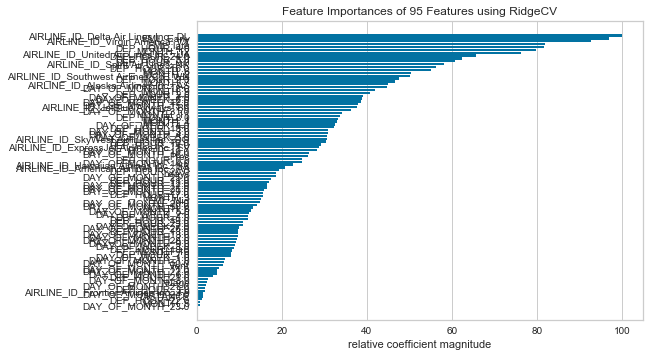

In [35]:
from yellowbrick.features.importances import FeatureImportances
viz = FeatureImportances(RidgeCV(), absolute=True)
viz.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
viz.poof()
plt.show()

Text(0.5,1,'Importance relative des 10 principales features, Ridge')

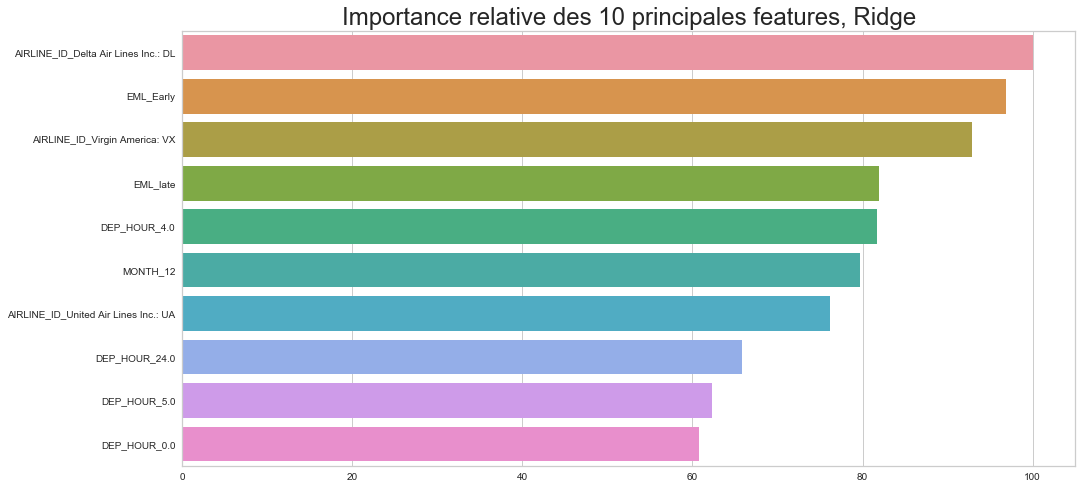

In [36]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
sns.barplot(y=viz.features_[::-1][0:10], x=(viz.feature_importances_[::-1][0:10]))
plt.title('Importance relative des 10 principales features, Ridge', fontsize=24)

Text(0.5,1,'Importance relative des 10 principales features, Ridge')

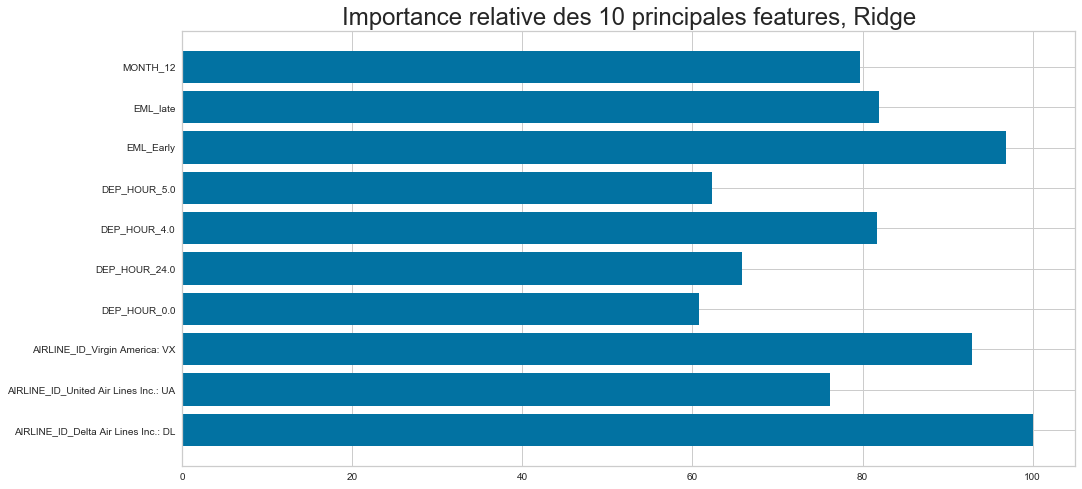

In [37]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
Labels = viz.features_[::-1][0:10]
plt.barh(y=viz.features_[::-1][0:10], width=viz.feature_importances_[::-1][0:10])
plt.title('Importance relative des 10 principales features, Ridge', fontsize=24)

In [38]:
Labels = viz.features_[::-1][0:10]
print(Labels)

['AIRLINE_ID_Delta Air Lines Inc.: DL' 'EML_Early'
 'AIRLINE_ID_Virgin America: VX' 'EML_late' 'DEP_HOUR_4.0' 'MONTH_12'
 'AIRLINE_ID_United Air Lines Inc.: UA' 'DEP_HOUR_24.0' 'DEP_HOUR_5.0'
 'DEP_HOUR_0.0']


## Regression Lasso 

In [39]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
Pred = lasso.predict(X_test)
error = np.mean((Pred - y_test) ** 2)
print('score on train is : ', lasso.score(X_train, y_train))
print('total error is : ', error)
print('MAE is : ', mean_absolute_error(y_test, Pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, Pred)))

score on train is :  0.0
total error is :  276.25016767098197
MAE is :  12.150355511869911
RMSE is :  16.620775182613535


In [40]:
n_alphas = 20
alphas = np.logspace(-4, 1, n_alphas)
lasso = Lasso()
coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean(
        (lasso.predict(X_test) - y_test) ** 2)])

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Visualisation de l'erreur selon le paramètre alpha

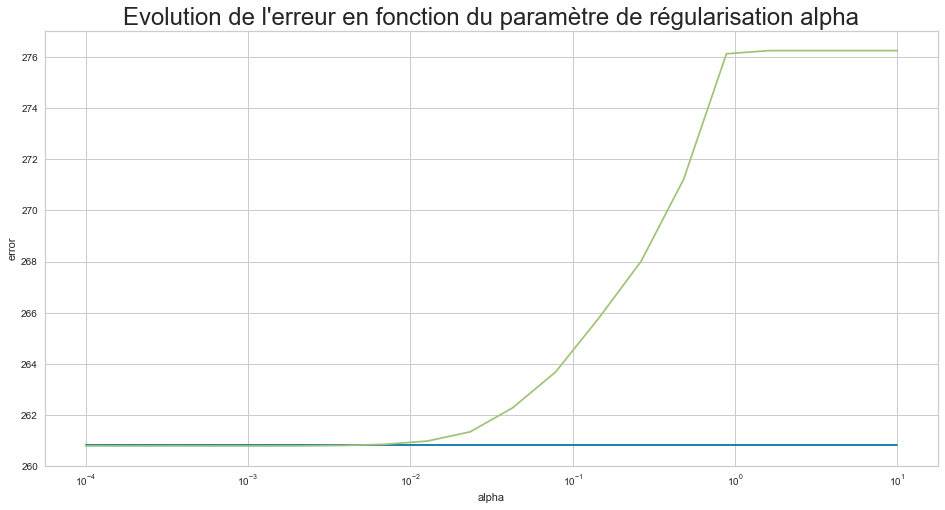

In [41]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title("Evolution de l'erreur en fonction du paramètre de régularisation alpha",  fontsize=24)
plt.axis('tight')
plt.show()

### Visualisation de l'évolution des paramètres selon alpha

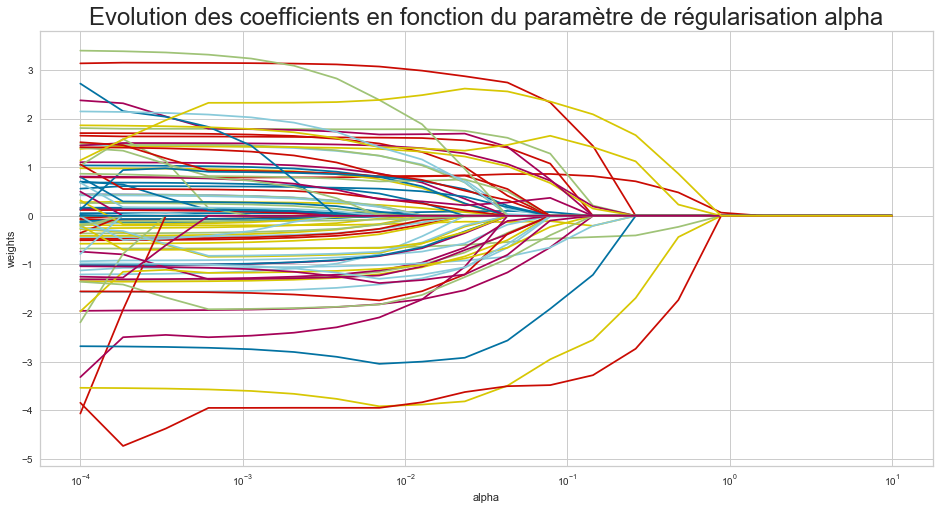

In [42]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title("Evolution des coefficients en fonction du paramètre de régularisation alpha",  fontsize=24)
plt.axis('tight')
plt.show()

Visualisation de l'importance des features  

Modèle permettant l'optimisation automatique du paramètre alpha

In [43]:
from sklearn.linear_model import LassoCV
LCV = LassoCV()
LCV.fit(X_train, y_train)
Pred = LCV.predict(X_test)
error = np.mean((Pred - y_test) ** 2)
print('score on train is : ', lasso.score(X_train, y_train))
print('total error is : ', error)
print('MAE is : ', mean_absolute_error(y_test, Pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, Pred)))

score on train is :  0.0
total error is :  260.78556732777446
MAE is :  11.86091659227415
RMSE is :  16.14885653313492


In [44]:
from yellowbrick.features.importances import FeatureImportances
viz = FeatureImportances(LassoCV(), absolute=True)
viz.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
viz.poof()
plt.show()

In [45]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
sns.barplot(y=viz.features_[::-1][0:10], x=(viz.feature_importances_[::-1][0:10]))
plt.title('Importance relative des 10 principales features', fontsize=24)

Text(0.5,1,'Importance relative des 10 principales features')

Text(0.5,1,'Importance relative des 10 principales features, Lasso')

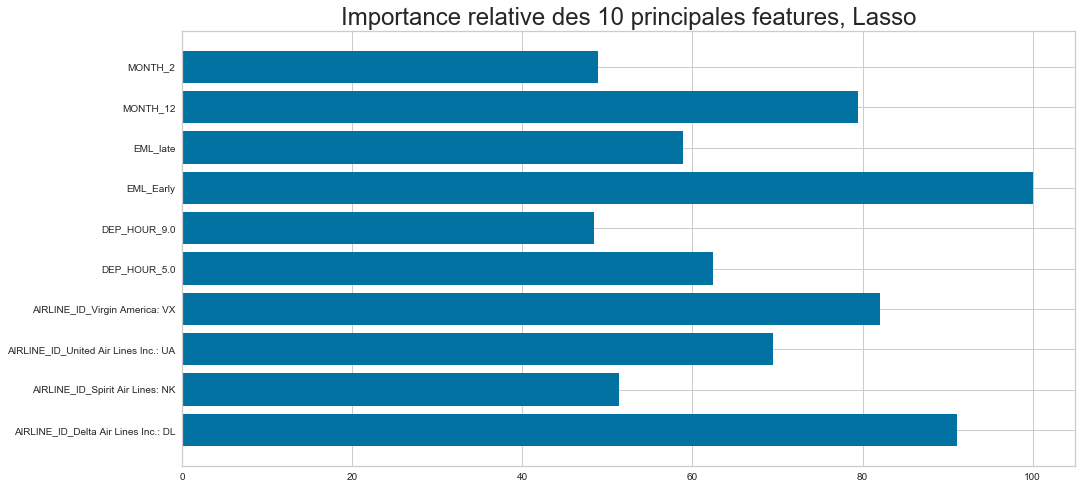

In [46]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
Labels = viz.features_[::-1][0:10]
plt.barh(y=Labels, width=viz.feature_importances_[::-1][0:10])
plt.title('Importance relative des 10 principales features, Lasso', fontsize=24)

## Elastic Net

In [47]:
from sklearn.linear_model import ElasticNetCV
EN = ElasticNetCV()
EN.fit(X_train, y_train)
Pred = EN.predict(X_test)
error = np.mean((Pred - y_test) ** 2)
print('score on train is : ', EN.score(X_train, y_train))
print('total error is : ', error)
print('MAE is : ', mean_absolute_error(y_test, Pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, Pred)))

score on train is :  0.05530631533430109
total error is :  260.7868779436985
MAE is :  11.859796093916861
RMSE is :  16.148897112301462


In [48]:
from yellowbrick.features.importances import FeatureImportances
viz = FeatureImportances(ElasticNetCV(), absolute=True)
viz.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
viz.poof()
plt.show()

In [49]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
sns.barplot(y=viz.features_[::-1][0:10], x=(viz.feature_importances_[::-1][0:10]))
plt.title('Importance relative des 10 principales features, ElasticNet', fontsize=24)

Text(0.5,1,'Importance relative des 10 principales features, ElasticNet')

In [50]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
Labels = viz.features_[::-1][0:10]
plt.barh(y=Labels, width=viz.feature_importances_[::-1][0:10])
plt.title('Importance relative des 10 principales features, ElasticNet', fontsize=24)

Text(0.5,1,'Importance relative des 10 principales features, ElasticNet')

# SGD Regressor

In [51]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
SGD_params = {'alpha': 10.0**-np.arange(1, 7)}  # Suggested range we try
SGD_model = GridSearchCV(SGDRegressor(
    random_state=0, max_iter = 500, tol=0.001), SGD_params, scoring='neg_mean_absolute_error', cv=5)  # Use 5-fold CV
SGD_model.fit(X_train, y_train)  # Fit the model

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=500, n_iter=None, penalty='l2',
       power_t=0.25, random_state=0, shuffle=True, tol=0.001, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [52]:
from sklearn.metrics import mean_absolute_error
    
y_true, y_pred = y_test, SGD_model.predict(X_test) # Predict on our test set
    
print ('Mean absolute error of SGD regression was:')
print(mean_absolute_error(y_true, y_pred))
print('MAE is : ', mean_absolute_error(y_test, y_pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error of SGD regression was:
11.728798042432373
MAE is :  11.728798042432373
RMSE is :  16.190883032551294


In [53]:
viz = FeatureImportances(SGDRegressor(), absolute=True)
viz.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
viz.poof()
plt.show()

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [54]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
sns.barplot(y=viz.features_[::-1][0:10], x=(viz.feature_importances_[::-1][0:10]))
plt.title('Importance relative des 10 principales features, SGDRegressor', fontsize=24)

Text(0.5,1,'Importance relative des 10 principales features, SGDRegressor')

Text(0.5,1,'Importance relative des 10 principales features, SGDRegressor')

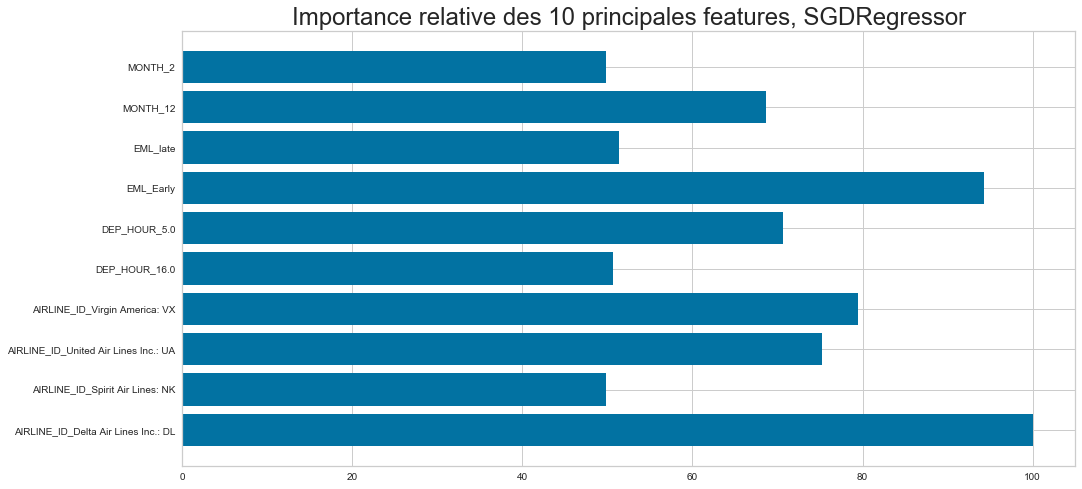

In [55]:
plt.figure(figsize=(16, 8))
L = len(viz.features_)
Labels = viz.features_[::-1][0:10]
plt.barh(y=Labels, width=viz.feature_importances_[::-1][0:10])
plt.title('Importance relative des 10 principales features, SGDRegressor', fontsize=24)

# Export du Modèle

In [56]:
import pickle 
with open('RCV.pkl', 'wb') as fid:
    pickle.dump(RCV, fid,2) 

In [ ]:
#Create a Dataframe with only the dummy variables
cat = data.drop('ARR_DELAY',axis=1)
index_dict = dict(zip(cat.columns,range(cat.shape[1])))

with open('cat', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 

# Filtrage des outliers

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor()
LOF_score = LOF.fit_predict(X_train)
#LOF_outlier = np.where(LOF.fit_predict(X_train) == -1)
print('il y a ', np.bincount(LOF_score + 1)[0], ' outliers detectés')

In [ ]:
print(X_train.shape)
X_train.index = range(0,len(X_train))
X_train = X_train.drop(np.where(LOF_score == -1)[0], axis=0)
print(X_train.shape)



In [ ]:
# Resoudre suppression des lignes pour y 
print(y_train.shape)
y_train = np.delete(y_train, np.where(LOF_score == -1))
print(y_train.shape)

In [ ]:
# print(LOF_score[0:50])
len(np.where(LOF_score == -1)[0])

Essayons de construire de nouveaux modèles avec nos données Train diminuées de ses outliers, afin de savoir si ce traitement améliore le modèle

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)
Pred = LR.predict(X_test)
baseline_error = np.mean((pred - y_test) ** 2)
print('score on train is : ', LR.score(X_train, y_train))
print('total error is : ', baseline_error)
print('MAE is : ', mean_absolute_error(y_test, Pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, Pred)))

## Ridge

In [ ]:
from sklearn.linear_model import RidgeCV
RCV = RidgeCV()
RCV.fit(X_train, y_train)
Pred = RCV.predict(X_test)
error = np.mean((Pred - y_test) ** 2)
print('score on train is : ', RCV.score(X_train, y_train))
print('total error is : ', error)
print('MEA is : ', mean_absolute_error(y_test, Pred))
print('RMSE is : ', sqrt(mean_squared_error(y_test, Pred)))